In [134]:
import numpy as np
import pandas as pd
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from utils import rgb2gray
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.svm import SVC
from SVM import OVO_test, OVO_train

In [135]:
Xtr = pd.read_csv('data/Xtr.csv',header=None,sep=',',usecols=range(3072))
Xte = pd.read_csv('data/Xte.csv',header=None,sep=',',usecols=range(3072))
Ytr_ = pd.read_csv('data/Ytr.csv')#, index_col = None, header = None)

In [136]:
Xtr = np.array(Xtr).reshape(5000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Xte = np.array(Xte).reshape(2000, 3,32, 32).swapaxes(1,2).swapaxes(2,3)
Ytr = np.array(Ytr_['Prediction'])

#Xtr_ = rgb2gray(Xtr)
#Xte_ = rgb2gray(Xte)

# Feature learning

In [137]:
#def whiten_patches(patches):
#    
#    res = np.zeros(patches.shape)
#    n_patches = len(patches)
#    patch_size = patches[0].shape[0]
#    cov = np.zeros((patch_size**2, patch_size**2))
#    
#    for patch in patches:
#        x = patch.reshape(-1,1)
#        cov += (x@x.T)/n_patches
#
#    D, E = np.linalg.eigh(cov)
#    D = np.diag(1/np.sqrt(D))
#    for i, patch in enumerate(patches):
#        x = patch.reshape(-1,1)
#        x_w = E@D@E@x
#        res[i] = x_w.reshape(6,6)
#    return res

def whiten_patches(patches):
    """ whiten """
    feats = patches.reshape(len(patches), -1)
    C = np.cov(feats, rowvar=False)  # 108 x 108 (for 6x6x3 kernels)
    M = np.mean(feats, axis=0)
    d, V = np.linalg.eig(C)
    D = np.diag(np.sqrt(1. / (d + 0.1)))
    P = np.matmul(np.matmul(V, D), V.T)
    feats = np.matmul(feats - M, P)

    return feats, M, P 


In [142]:
patch_size = 6

def extract_patch(image, patch_size):
    corner = np.random.randint(32 - patch_size, size=2)
    i,j = corner[0], corner[1]
    patch = image[i:i+patch_size, j:j+patch_size, :]
    patch = patch - np.mean(patch)
    if np.std(patch) > 0:
        patch/=np.std(patch)
    return patch


def extract_patches(dataset, num_patches, patch_size):
    patches = np.zeros((num_patches, patch_size, patch_size, 3))
    for i in tqdm(range(num_patches)):
        n=len(dataset)
        idx = np.random.randint(n)
        patch = extract_patch(dataset[idx], patch_size)
        patches[i] = patch
    return patches

def cluster_patches(patches, k):
    n = len(patches)
    data = patches.reshape(n,-1)
    clust = KMeans(n_clusters=k)
    clust.fit(data)
    return clust.labels_, clust.cluster_centers_


In [144]:
extract_patch(Xtr[0], 6).shape

(6, 6, 3)

In [145]:
patches = extract_patches(Xtr, 200000, 6)

100%|████████████████████████████████| 200000/200000 [00:13<00:00, 14378.25it/s]


In [147]:
patches = whiten_patches(patches)[0]

In [148]:
labels, centroids = cluster_patches(patches, 400)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

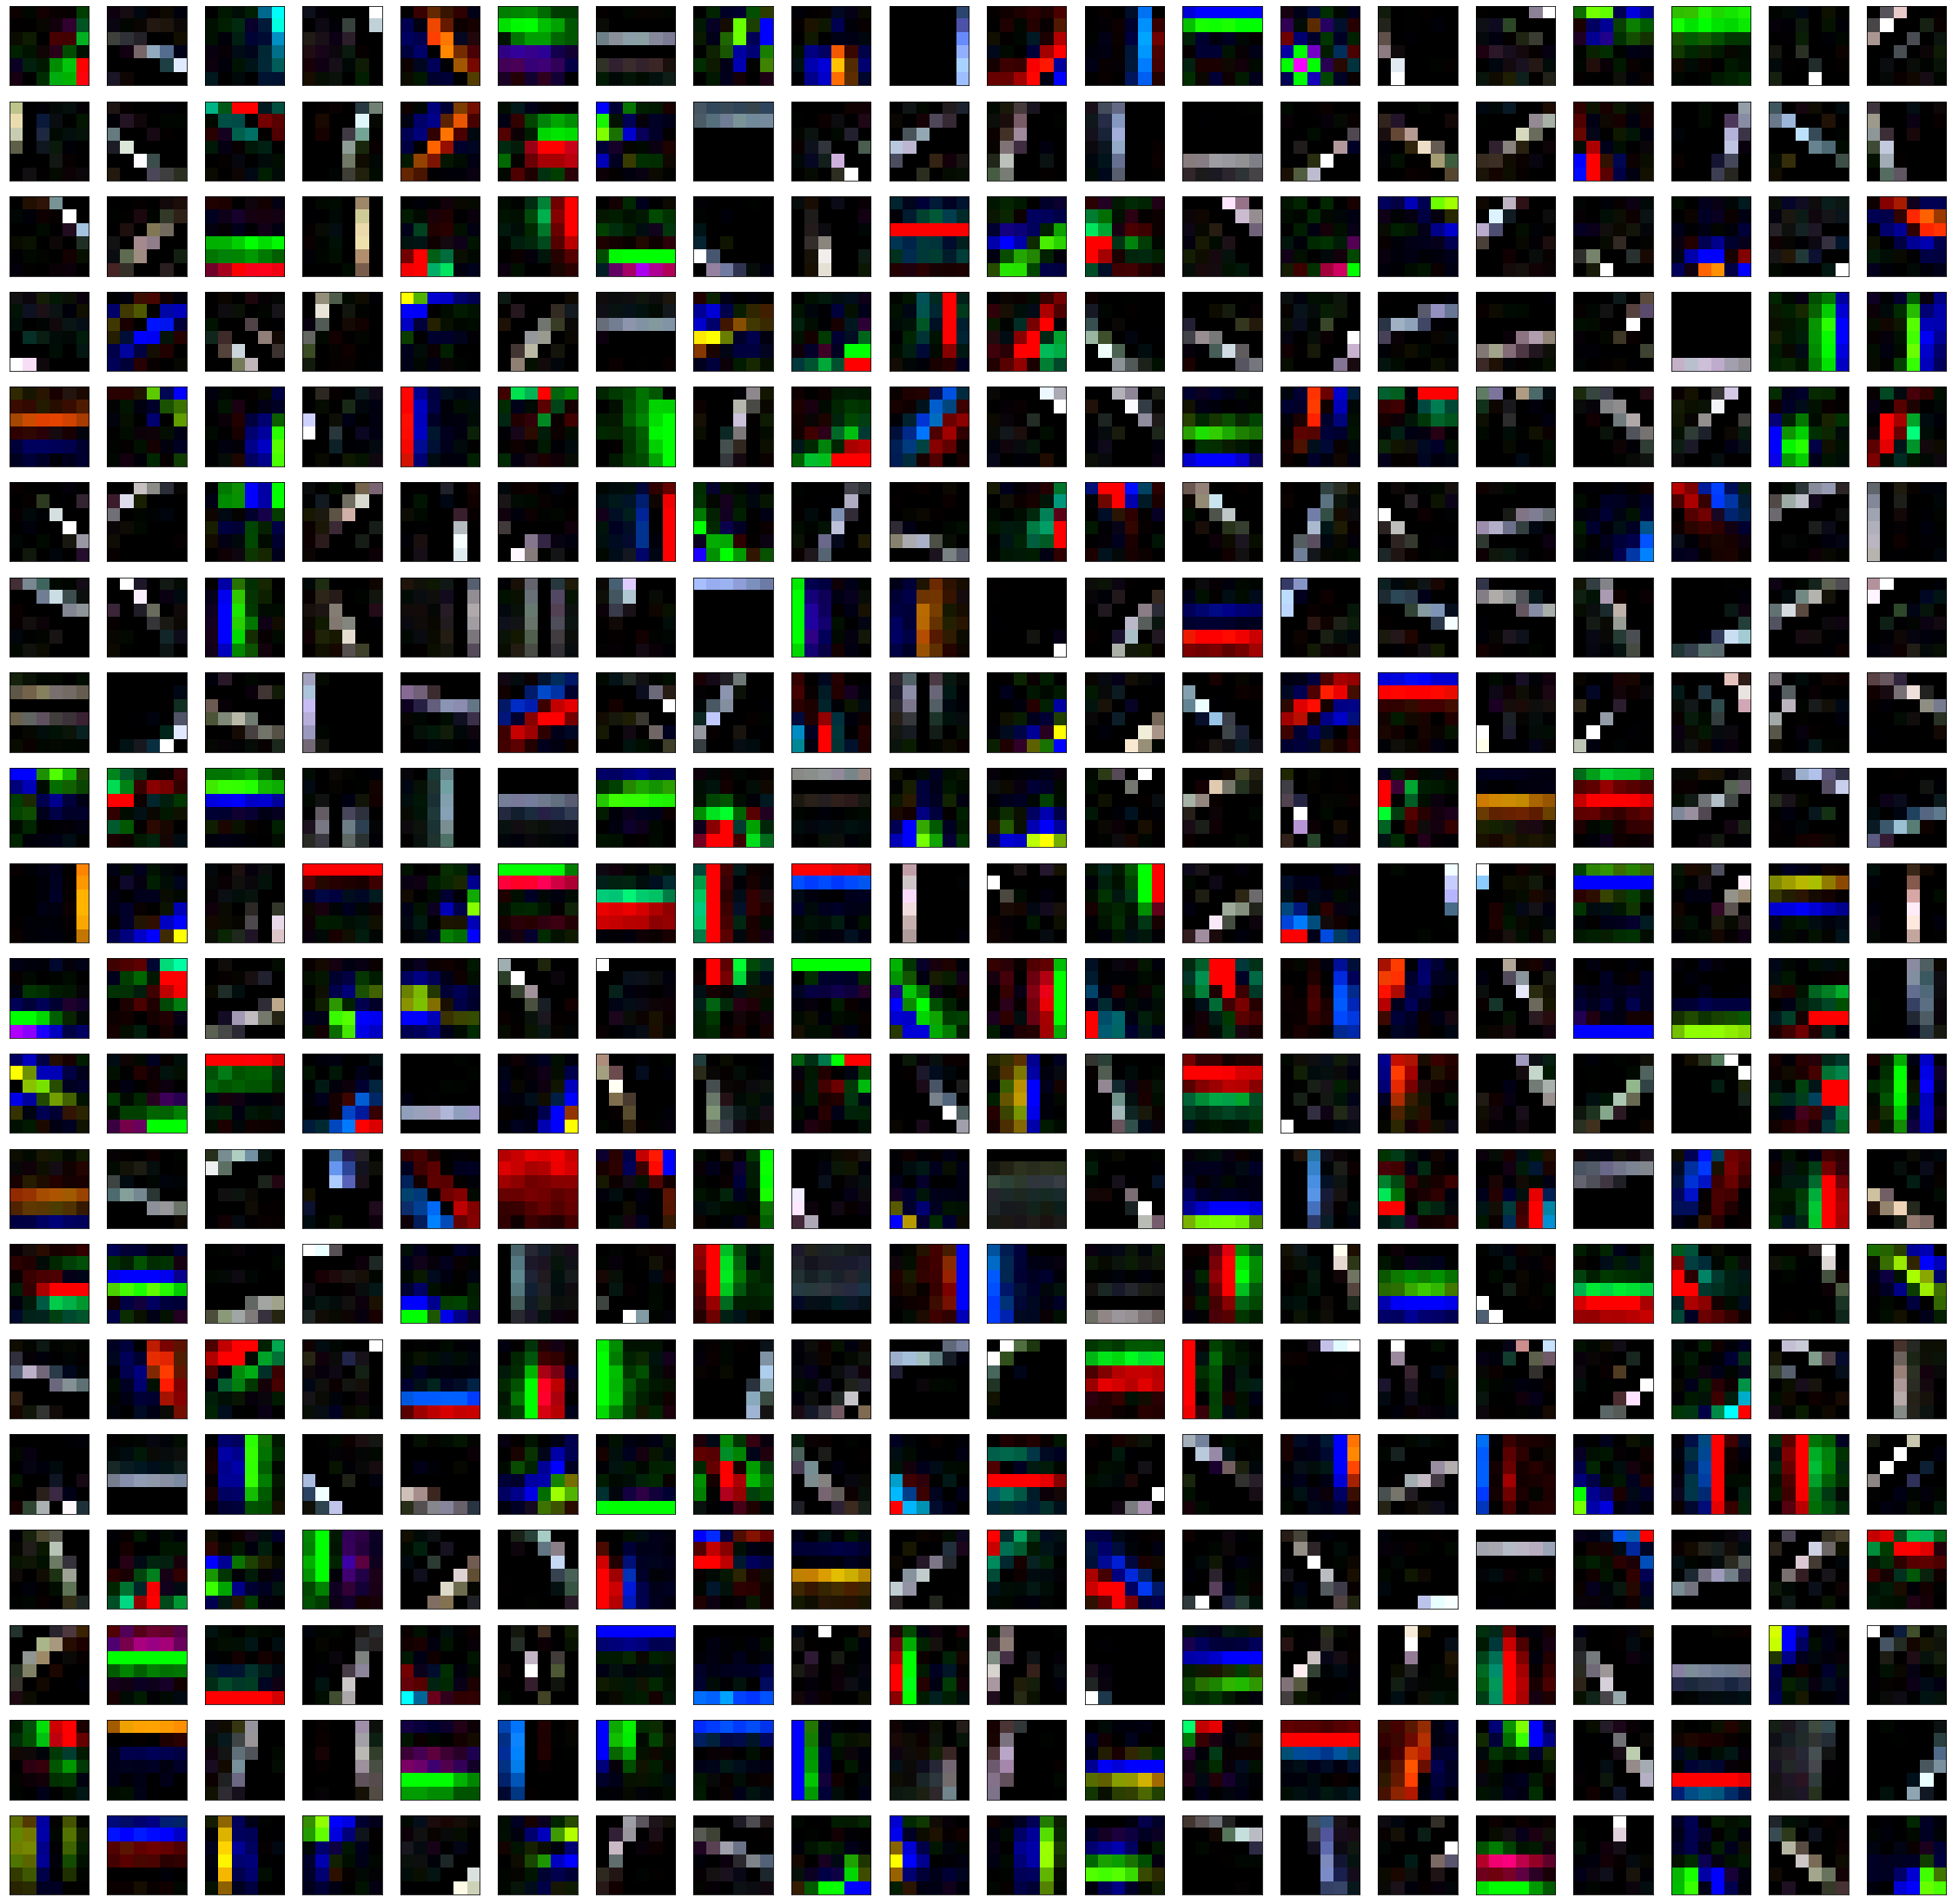

In [149]:
fig, ax = plt.subplots(20,20, figsize = (40,40))
idx = 0
for i in range(20):
    for j in range(20):
        ax[i,j].imshow(centroids[idx].reshape(6, 6, 3))
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
        idx+=1

# Feature extraction

In [150]:
def get_quarters(img):
    img_size = img.shape[0]
    half_size = img_size//2
    q1 = img[:half_size, :half_size,:]
    q2 = img[half_size:, :half_size,:]
    q3 = img[:half_size, half_size:,:]
    q4 = img[half_size:, half_size:,:]
    return [q1, q2, q3, q4]

def compute_features_patch(patch, centroids):
    k = len(centroids)
    z = np.zeros(k)
    for i, centroid in enumerate(centroids):
        z[i] = np.linalg.norm(patch.reshape(-1) - centroid)
    f =  np.maximum(np.zeros(k), np.mean(z)*np.ones(k) - z)
    return f

def compute_features_img(img, centroids, stride, patch_size):
    k = len(centroids)
    img_feat = np.zeros(k)
    img_size = img.shape[0]
    i = 0
    while i+patch_size < img_size:
        j = 0
        while j+patch_size < img_size:
            patch = img[i:i+patch_size, j:j+patch_size,:]
            j+=stride
            f = compute_features_patch(patch, centroids)
            img_feat += f
            #print(i,j)
        i+=stride
    return img_feat

def compute_features(dataset, centroids, stride, patch_size):
    X = []    
    for img in tqdm(dataset):
        quart = get_quarters(img)
        f = []
        for i in range(4):
            quarter_feats = compute_features_img(quart[i], centroids, stride, patch_size)
            #shape num_patches_in_quarter x k
            f.append(quarter_feats) #only k features per quarter
        #print(f.shape)
        X.append(f)
    X = np.array(X)
    X = X.reshape(len(X), -1)
    X -= X.mean(axis=0, keepdims=True)
    #X /= np.std(X, axis=0)
    return X

In [155]:
#dataset = Xtr_
#dataset.shape
X_train = compute_features(Xtr, centroids, stride=2, patch_size=6)
X_test = compute_features(Xte, centroids, stride=2, patch_size=6)

100%|███████████████████████████████████████| 2000/2000 [06:55<00:00,  4.81it/s]


<AxesSubplot:>

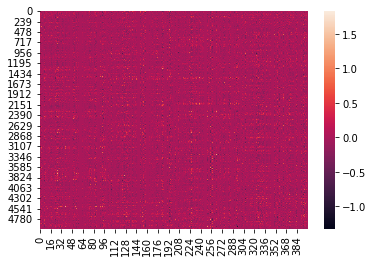

In [156]:
import seaborn as sns
sns.heatmap(X)

In [157]:
np.save('X_train', X_train)
np.save('X_test', X_test)

X_train = np.load('X_train.npy')
X_test= np.load('X_test.npy')

In [158]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_tr, X_te, y_tr, y_te = train_test_split(X_train, Ytr, test_size=0.33, random_state=42)

In [167]:
classifier = SVC(C=0.1, decision_function_shape='ovo')
classifier.fit(X_tr, y_tr)

SVC(C=0.1, decision_function_shape='ovo')

In [168]:
pred = classifier.predict(X_te)

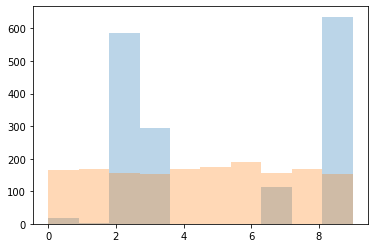

In [169]:
plt.hist(pred, alpha=0.3)
plt.hist(y_te, alpha=0.3)
plt.show()

In [170]:
accuracy_score(pred, y_te)

0.1690909090909091